# Import Required Libraries

In [17]:
from IPython.display import Markdown, display
from scipy.stats import norm
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import config

# Load the active members data

In [18]:
active_members_extra_interim_df = pd.read_csv(config.ACTIVE_MEMBERS_EXTRA_INTERIM)
active_members_extra_interim_df.head()

,MEMBER_NUMBER,FIRST_NAME,LAST_NAME,PRIMARY_EMAIL,ADDRESS1,ADDRESS2,CITY,STATE,ZIP,COUNTRY,...,PRIMARY_MEMBER_NUMBER,AGREED_TO_PRIVACY_TERMS,ALLOW_MARKETING,EMERGENCY_CONTACT_NAME,EMERGENCY_CONTACT_RELATIONSHIP,EMERGENCY_CONTACT_PHONE,EMERGENCY_CONTACT_EMAIL,PRONOUN_NAME,AUTOMATIC_RENEWAL_OPT_IN,LAST_LOGIN_DATETIME
0,108,Jeff,Miller,jeffonthefly@gmail.com,65 Westward Way,NaN,Rockcliffe Park,ON,K1L 5A8,Canada,...,NaN,Yes,Unknown,Marcie Lorenzen,Spouse,613-858-8221,mjlorenzen64@gmail.com,No Preference,No,2024-11-16 15:05:00
1,081,Mark,Hill,membership@bmwmcottawa.ca,20 Beamish Cres,NaN,Kanata,ON,K2K 2R6,Canada,...,NaN,Yes,Unknown,Kathy Hill,Spouse,613-724-8618,kathyhill@rogers.com,No Preference,No,2024-11-23 09:37:00
2,122,Fiona,Brown,president@bmwmcottawa.ca,398 Gold Creek Rd,NaN,Lanark,ON,K0G 1K0,Canada,...,NaN,Yes,Unknown,Donald Mann,Partner,(613) 462-4621,norton961@tutanota.com,No Preference,No,2024-11-22 18:04:00
3,275,Amy,Phinney,amy.phinney@hotmail.ca,312 Centenaire St,NaN,Embrun,ON,K0A 1W0,Canada,...,NaN,Yes,Unknown,Glen Phinney,Spouse,343-543-5398,glen.phinney@forces.gc.ca,No Preference,No,2024-11-15 10:56:00
4,100,John,Lang,johnhughlang@gmail.com,#1104 - 1425 Vanier Parkway,NaN,Ottawa,ON,K1K 3W6,Canada,...,NaN,Yes,Unknown,Madelien Lang,Spouse,613-415-2701,madelienlang@gmail.com,No Preference,No,2024-11-13 06:19:00


# Gender Demographic Table

In [19]:
def totalMemberCount(df):
    return df["MEMBER_COUNT"].sum()


def createGenderData(df):
    # Work on a copy of the dataframe
    df_copy = df.copy()
    # Group by GENDER and count MEMBER_ID
    gender_data_df = df_copy.groupby("GENDER")["MEMBER_NUMBER"].count().reset_index()
    gender_data_df.columns = ["GENDER", "MEMBER_COUNT"]
    # Calculate percentage
    total_count = totalMemberCount(gender_data_df)
    gender_data_df["PERCENTAGE"] = (gender_data_df["MEMBER_COUNT"] / total_count) * 100
    return gender_data_df


def renderGenderData(df):
    # Render a markdown table with columns Gender, Member Count, and Percentage
    table_md = "| Gender | Member Count | Percentage |\n|--------|--------------|------------|\n"
    for index, row in df.iterrows():
        table_md += f"| {row['GENDER']} | {row['MEMBER_COUNT']} | {row['PERCENTAGE']:.1f}% |\n"
    table_md += f"| **Total** | **{totalMemberCount(df)}** | **100.0%** |"
    display(Markdown(table_md))


gender_data_df = createGenderData(active_members_extra_interim_df)
renderGenderData(gender_data_df)

# For TextWrangler
gender_data_df.head()

| Gender | Member Count | Percentage |
|--------|--------------|------------|
| Female | 45 | 17.9% |
| Male | 206 | 82.1% |
| **Total** | **251** | **100.0%** |

,GENDER,MEMBER_COUNT,PERCENTAGE
0,Female,45,17.928287
1,Male,206,82.071713


# Gender Demographic Chart

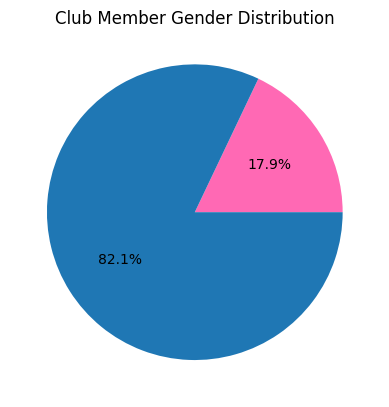

GENDER
Female     45
Male      206
Name: MEMBER_COUNT, dtype: int64

In [20]:
# Assign colors to genders
colors = {"Male": config.GENDER_BLUE, "Female": config.GENDER_PINK}

# Use gender_data_df to get the gender distribution
gender_demographic_df = gender_data_df.set_index("GENDER")["MEMBER_COUNT"]

# Plot the distribution of members
gender_demographic_df.plot(
    kind="pie",
    labels=[""] * len(gender_data_df),
    colors=[colors[key] for key in gender_demographic_df.index],
    autopct="%1.1f%%",
)

# Add a title
plt.title("Club Member Gender Distribution", pad=0)

# Remove the axis
plt.axis("off")

# Save and show the plot
plt.savefig(config.CLUB_MEMBER_GENDER_DISTRIBUTION)
plt.show()

gender_demographic_df.head()

# Age & Gender Demographic Table

In [21]:
def createAgeAndGenderData(df):
    # Create a new dataframe from active_members_extra_interim_df
    age_gender_data_df = df.copy()
    age_gender_data_df = age_gender_data_df[["MEMBER_NUMBER", "DATE_OF_BIRTH", "GENDER"]]

    # Create the AGE column next to DATE_OF_BIRTH with int type and fill with 0
    age_gender_data_df.insert(age_gender_data_df.columns.get_loc("DATE_OF_BIRTH") + 1, "AGE", 0)

    # Calculate age and update the AGE column
    age_gender_data_df["AGE"] = (
        (pd.Timestamp("now").year - pd.to_datetime(age_gender_data_df["DATE_OF_BIRTH"]).dt.year)
        .fillna(0)
        .astype(int)
    )
    return age_gender_data_df


def addAgeBinsToData(df):
    # Define age buckets
    bins = [18, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = ["18-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"]
    df.insert(
        df.columns.get_loc("AGE") + 1,
        "AGE_BUCKET",
        pd.cut(df["AGE"], bins=bins, labels=labels, right=False),
    )
    # Include 'Unknown' in age buckets
    df["AGE_BUCKET"] = df["AGE_BUCKET"].cat.add_categories("Unknown").fillna("Unknown")
    return df


def groupByAgeBinsAndGender(df):
    # Group by age bucket and gender
    df = df.groupby(["AGE_BUCKET", "GENDER"], observed=False).size().unstack().fillna(0)
    return df


def addTotalColumn(df):
    df["Total"] = df.sum(axis=1)
    return df


def getAgeAndGenderData(df):
    df = createAgeAndGenderData(df)
    df = addAgeBinsToData(df)
    df = groupByAgeBinsAndGender(df)
    df = addTotalColumn(df)
    return df


def renderAgeAndGenderData(df):
    # Render a markdown table with columns Age Bucket, Female, Male, Total.
    # The last row should show the total for each column.
    table_md = "| Age Bucket | Female | Male | Total |\n|------------|--------|------|-------|\n"
    for index, row in df.iterrows():
        table_md += f"| {index} | {row['Female']} | {row['Male']} | {row['Total']} |\n"
    table_md += f"| **Total** | **{df['Female'].sum()}** | **{df['Male'].sum()}** | **{df['Total'].sum()}** |"
    display(Markdown(table_md))


age_gender_data_df = getAgeAndGenderData(active_members_extra_interim_df)
renderAgeAndGenderData(age_gender_data_df)

age_gender_data_df.head()

| Age Bucket | Female | Male | Total |
|------------|--------|------|-------|
| 18-30 | 0 | 2 | 2 |
| 31-40 | 0 | 1 | 1 |
| 41-50 | 3 | 14 | 17 |
| 51-60 | 12 | 58 | 70 |
| 61-70 | 11 | 56 | 67 |
| 71-80 | 1 | 29 | 30 |
| 81-90 | 0 | 6 | 6 |
| 91-100 | 0 | 0 | 0 |
| Unknown | 18 | 40 | 58 |
| **Total** | **45** | **206** | **251** |

GENDER,Female,Male,Total
AGE_BUCKET,,,
18-30,0,2,2
31-40,0,1,1
41-50,3,14,17
51-60,12,58,70
61-70,11,56,67


# Age & Gender Demographic Chart

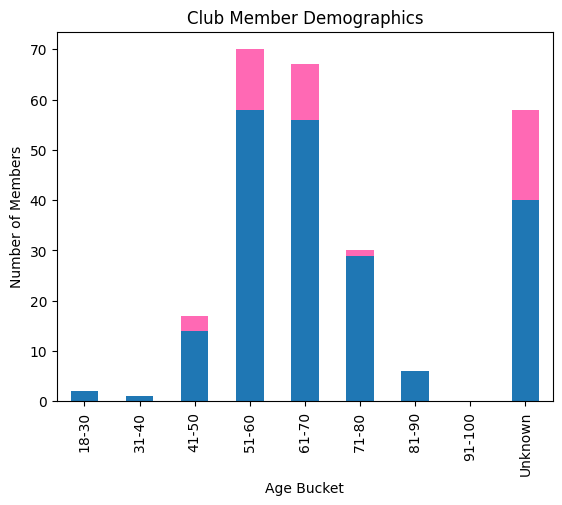

In [22]:
# Create a series with Age Bucket as index, Female, Male columns
# from age_gender_data_df
age_gender_series_df = age_gender_data_df[["Male", "Female"]]

# Plot the age and gender distribution
age_gender_series_df.plot(
    kind="bar", stacked=True, color=[config.GENDER_BLUE, config.GENDER_PINK], legend=True
)
plt.title("Club Member Demographics")
plt.xlabel("Age Bucket")
plt.ylabel("Number of Members")
plt.legend().set_visible(False)

# Save and show the plot
plt.savefig(config.CLUB_MEMBER_AGE_GENDER_DISTRIBUTION)
plt.show()

# Active Member Mean Age

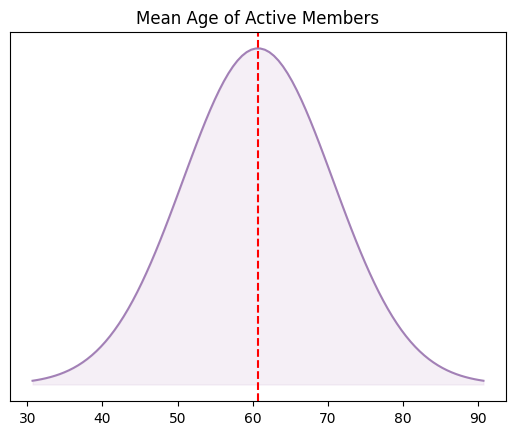

In [23]:
# Calculate the mean age of members
mean_age = (
    active_members_extra_interim_df["DATE_OF_BIRTH"]
    .dropna()
    .apply(lambda x: pd.Timestamp("now").year - pd.to_datetime(x).year)
    .mean()
)

# Plot a bell-shaped curve (normal distribution) for the mean age

# Generate data for the bell curve
x = np.linspace(mean_age - 3 * 10, mean_age + 3 * 10, 100)
y = norm.pdf(x, mean_age, 10)

# Plot the bell curve
plt.plot(x, y, label="Mean Age Distribution", color=config.GENDER_NEUTRAL)
plt.fill_between(x, y, alpha=0.2, color=config.GENDER_NEUTRAL_FILL)

# Add a vertical line at the mean age
plt.axvline(mean_age, color="red", linestyle="--", label=f"Mean Age: {mean_age:.1f}")

# Add title
plt.title("Mean Age of Active Members")

# Remove the y-axis
plt.gca().axes.get_yaxis().set_visible(False)

# Save and show the plot
plt.savefig(config.CLUB_MEMBER_MEAN_AGE_DISTRIBUTION)
plt.show()

# Active Member Median Age

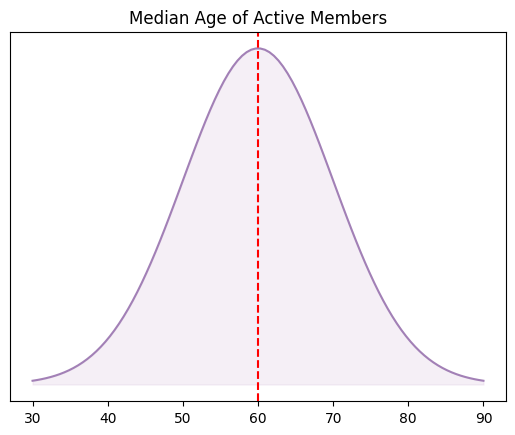

In [24]:
# Calculate the median age of members
median_age = (
    active_members_extra_interim_df["DATE_OF_BIRTH"]
    .dropna()
    .apply(lambda x: pd.Timestamp("now").year - pd.to_datetime(x).year)
    .median()
)

# Plot a bell-shaped curve (normal distribution) for the median age

# Generate data for the bell curve
x = np.linspace(median_age - 3 * 10, median_age + 3 * 10, 100)
y = norm.pdf(x, median_age, 10)

# Plot the bell curve
plt.plot(x, y, label="Median Age Distribution", color=config.GENDER_NEUTRAL)
plt.fill_between(x, y, alpha=0.2, color=config.GENDER_NEUTRAL_FILL)

# Add a vertical line at the median age
plt.axvline(median_age, color="red", linestyle="--", label=f"Median Age: {median_age:.1f}")

# Add title
plt.title("Median Age of Active Members")

# Remove the y-axis
plt.gca().axes.get_yaxis().set_visible(False)

# Add legend and show the plot
plt.savefig(config.CLUB_MEMBER_MEDIAN_AGE_DISTRIBUTION)
plt.show()